In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *

import os
import json
import sys

import random
import math
import datetime, timeit, time

spark = SparkSession.builder \
                    .master('local') \
                    .appName('rfm_test') \
                    .enableHiveSupport() \
                    .getOrCreate()

# sdf = spark.read.csv(r"part-00000-c3718e6e-4cb2-4233-86b6-173d00bff461-c000.csv", header=True)
# sdf.createOrReplaceTempView("sdf")
# sdf.cache()
# sdf.show()

os.chdir("C:\\Users\\123\\Desktop\\")
os.getcwd()

df = pd.read_csv(r"part-00000-c3718e6e-4cb2-4233-86b6-173d00bff461-c000.csv")
df.head()

,dpstr_cust_no,rct_dys,r,f,m
0,1344359386384,2022-07-07,8,3,1010600
1,1234750792344,2022-07-05,10,10,489790
2,1234296826081,2022-07-09,6,17,943110
3,1236261358203,2022-07-13,2,15,230600
4,1235100829011,2022-06-30,15,12,524100


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144660 entries, 0 to 144659
Data columns (total 5 columns):
dpstr_cust_no    144660 non-null int64
rct_dys          144660 non-null object
r                144660 non-null int64
f                144660 non-null int64
m                144660 non-null int64
dtypes: int64(4), object(1)
memory usage: 5.5+ MB


In [3]:
# RFM으로 고객분석 하는 방법은 여러가지가 있음
# 1. 고객의 R/F/M별 4등분 그룹핑 -> 64개 고객군 도출(예: 431, 233) -> concat해서 segmentation
# 2. 도메인에 맞게 자체적인 등급 그룹핑: 사분위수 구하여 구간별 1~4점 부여

# rfm = spark.sql("""
#     with rfm_base as (
#         select a.dpstr_cust_no
#             , max(a.std_dt) as rct_pch_dt                        -- 최근구매일
#             , datediff(current_date(), max(a.std_dt)) as diff    -- 구매경과일
#             , count(distinct a.std_dt) as pch_dys                -- 구매일수
#             , sum(a.gs_slng_amt) as pch_amt                      -- 구매금액
#         from lpciddm.tb_dmcs_dditmnocustitgslngdtl_f a
#         join lpciddm.tb_dmcs_mmcustinfo_f b
#             on a.dpstr_cust_no = b.dpstr_cust_no
#             and a.std_ym = b.std_ym
#         where 1 = 1
#             and a.std_dt between add_months(current_date(), -3) and current_date()
#             and a.cstr_cd = '0001'
#             and a.on_off_cl_cd = '1'
#         group by 1
#     ), rfm_base_v2 as (
#         select 
#         from rfm_base a
#     )
#     """)

sdf = spark.createDataFrame(df)
sdf.createOrReplaceTempView("sdf")
sdf.cache()

DataFrame[dpstr_cust_no: bigint, rct_dys: string, r: bigint, f: bigint, m: bigint]

In [11]:
rfm_recency = spark.sql("""
    select *
    from (select r
               , row_number() over(order by r asc) as rownum
               , round(row_number() over(order by r asc) * 100 / 87, 0) as quantile_base
          from sdf
          group by 1
         ) t
    where 1 = 1
        and ((t.quantile_base = 1) or (t.quantile_base = 25) or (t.quantile_base = 51) or (t.quantile_base = 75) or (t.quantile_base = 100))
    """)

rfm_frequency = spark.sql("""
    select * 
    from (select f
               , row_number() over(order by f desc) as rownum
               , round(row_number() over(order by f desc) * 100 / 73, 0) as quantile_base
          from sdf
          group by 1
         ) t
    where 1 = 1
        and ((t.quantile_base <= 1) or (t.quantile_base = 25) or (t.quantile_base = 51) or (t.quantile_base = 75) or (t.quantile_base = 100))
    """)    

rfm_monetary = spark.sql("""
    select t.ntile_div
         , max(m) as min_value
    from (select m
              ,  ntile(4) over(order by m desc) as ntile_div
          from sdf
         ) t
    group by 1
   """)

rfm_recency.createOrReplaceTempView("rfm_recency")
rfm_frequency.createOrReplaceTempView("rfm_frequency")
rfm_monetary.createOrReplaceTempView("rfm_monetary")

rfm_recency.cache()
rfm_frequency.cache()
rfm_monetary.cache()

rfm_recency.show()
rfm_frequency.show()
rfm_monetary.show()

+---+------+-------------+
|  r|rownum|quantile_base|
+---+------+-------------+
|  2|     1|          1.0|
| 24|    22|         25.0|
| 47|    44|         51.0|
| 68|    65|         75.0|
| 91|    87|        100.0|
+---+------+-------------+

+---+------+-------------+
|  f|rownum|quantile_base|
+---+------+-------------+
| 79|     1|          1.0|
| 56|    18|         25.0|
| 37|    37|         51.0|
| 19|    55|         75.0|
|  1|    73|        100.0|
+---+------+-------------+

+---------+---------+
|ntile_div|min_value|
+---------+---------+
|        1|422406430|
|        2|   475240|
|        3|   139000|
|        4|    38200|
+---------+---------+



In [4]:
rfm_modified = spark.sql("""
    with rfm_final as (          
        select a.dpstr_cust_no
             , case when ((r >= 0) and (r <= 24)) then 4 
                    when ((r > 24) and (r <= 47)) then 3 
                    when ((r > 47) and (r <= 68)) then 2
                    else 1 end as recency
             , case when (f >= 56) then 4 
                    when ((f >= 37) and (f < 56)) then 3 
                    when ((f >= 19) and (f < 37)) then 2
                    else 1 end as frequency
             , case when (m >= 475240) then 4 
                    when ((m >= 139000) and (m < 475240)) then 3 
                    when ((m >= 38200) and (m < 139000)) then 2
                    else 1 end as monetary
        from sdf a
        )
        select a.*
             , concat(a.recency, a.frequency, a.monetary) as rfm_concat 
             , round((a.recency * 1) + (a.frequency * 1) + (a.monetary * 1), 0) as rfm_score
        from rfm_final a
            
    """)

rfm_modified.createOrReplaceTempView("rfm_modified")
rfm_modified.cache()
rfm_modified.show()

+-------------+-------+---------+--------+----------+---------+
|dpstr_cust_no|recency|frequency|monetary|rfm_concat|rfm_score|
+-------------+-------+---------+--------+----------+---------+
|1344359386384|      4|        1|       4|       414|        9|
|1234750792344|      4|        1|       4|       414|        9|
|1234296826081|      4|        1|       4|       414|        9|
|1236261358203|      4|        1|       3|       413|        8|
|1235100829011|      4|        1|       4|       414|        9|
|1234625461233|      4|        3|       4|       434|       11|
|1237702524162|      4|        1|       4|       414|        9|
|1236584695071|      4|        1|       4|       414|        9|
|1234482801233|      4|        1|       4|       414|        9|
|1236732424566|      4|        1|       3|       413|        8|
|1344553798506|      3|        1|       2|       312|        6|
|1234156513556|      4|        1|       4|       414|        9|
|1345247662748|      1|        1|       

In [5]:
rfm = rfm_modified.toPandas()
rfm.head()

,dpstr_cust_no,recency,frequency,monetary,rfm_concat,rfm_score
0,1344359386384,4,1,4,414,9
1,1234750792344,4,1,4,414,9
2,1234296826081,4,1,4,414,9
3,1236261358203,4,1,3,413,8
4,1235100829011,4,1,4,414,9


In [6]:
rfm_manipulated = rfm.groupby('rfm_concat')['dpstr_cust_no'].agg(['count']).reset_index().sort_values(by='rfm_concat', ascending=False)
rfm_manipulated

,rfm_concat,count
29,444,35
28,442,1
27,434,320
26,433,21
25,432,1
24,431,2
23,424,1556
22,423,307
21,422,8
20,421,7


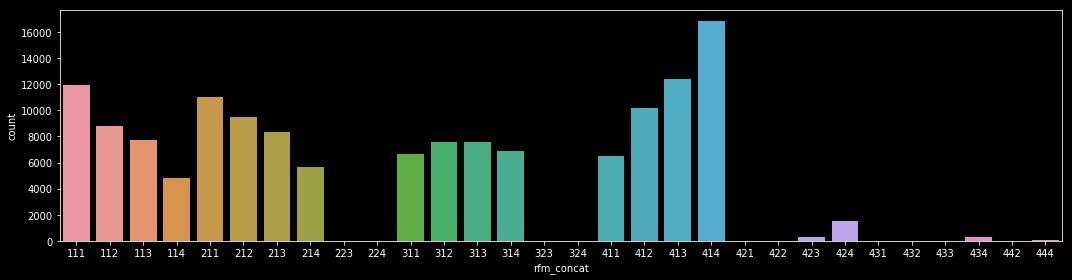

In [7]:
plt.style.use('dark_background')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
sns.barplot(x='rfm_concat', y='count', data=rfm_manipulated, ax=ax, )
plt.tight_layout()

# 우수고객(44x, 43x, 34x): 우수고객 특별/감사 사은/이벤트 
# 신규유입고객(41x, 42x): 구매금액 range에 따라, 우수고객 가능성 높은 고객들에게 특별 사은/혜택 안내
# 일반고객(=재구매고객): 
# 이탈위험고객(31x, 32x): 이탈위험 대상에게만 초대회/커피쿠폰 등 안내

# 우수고객 한정 10% 추가 D/C (에누리)
# LMS 수신고객 대상 우수고객라운지 커피쿠폰 증정
# 감사품/상품권 교환 이벤트
# LMS 수신고객 중 선착순 n명 한정 20% D/C, 무료주차권 증정, 초대회 안내

In [8]:
rfm['rfm_concat'] = rfm['rfm_concat'].astype('int32')
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144660 entries, 0 to 144659
Data columns (total 6 columns):
dpstr_cust_no    144660 non-null int64
recency          144660 non-null int32
frequency        144660 non-null int32
monetary         144660 non-null int32
rfm_concat       144660 non-null int32
rfm_score        144660 non-null int32
dtypes: int32(5), int64(1)
memory usage: 3.9 MB


In [9]:
len(rfm[rfm['rfm_concat'] == 424]['dpstr_cust_no'])

1556

In [10]:
rfm_sql = spark.createDataFrame(rfm)

rfm_sql.createOrReplaceTempView("rfm_sql")
rfm_sql.cache()

verf = spark.sql("""
          
          select dpstr_cust_no
          from rfm_sql
          where 1 = 1
            and rfm_concat = 424
          
          """)

verf.cache()
verf.show()

+-------------+
|dpstr_cust_no|
+-------------+
|1237172057698|
|1234694847395|
|1234609366384|
|1234432986687|
|1344712418405|
|1236262389011|
|1234489657395|
|1236729542243|
|1236236870829|
|1234647755172|
|1235335836586|
|1234552010728|
|1344967131839|
|1236503450728|
|1234406090829|
|1234691719314|
|1235365774667|
|1235127777294|
|1344636869112|
|1235374032950|
+-------------+
only showing top 20 rows

